In [1]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import random
import scipy.stats as sts
from IPython.display import display
import tqdm

# **Topology of Interest**

**Original Topology Map**

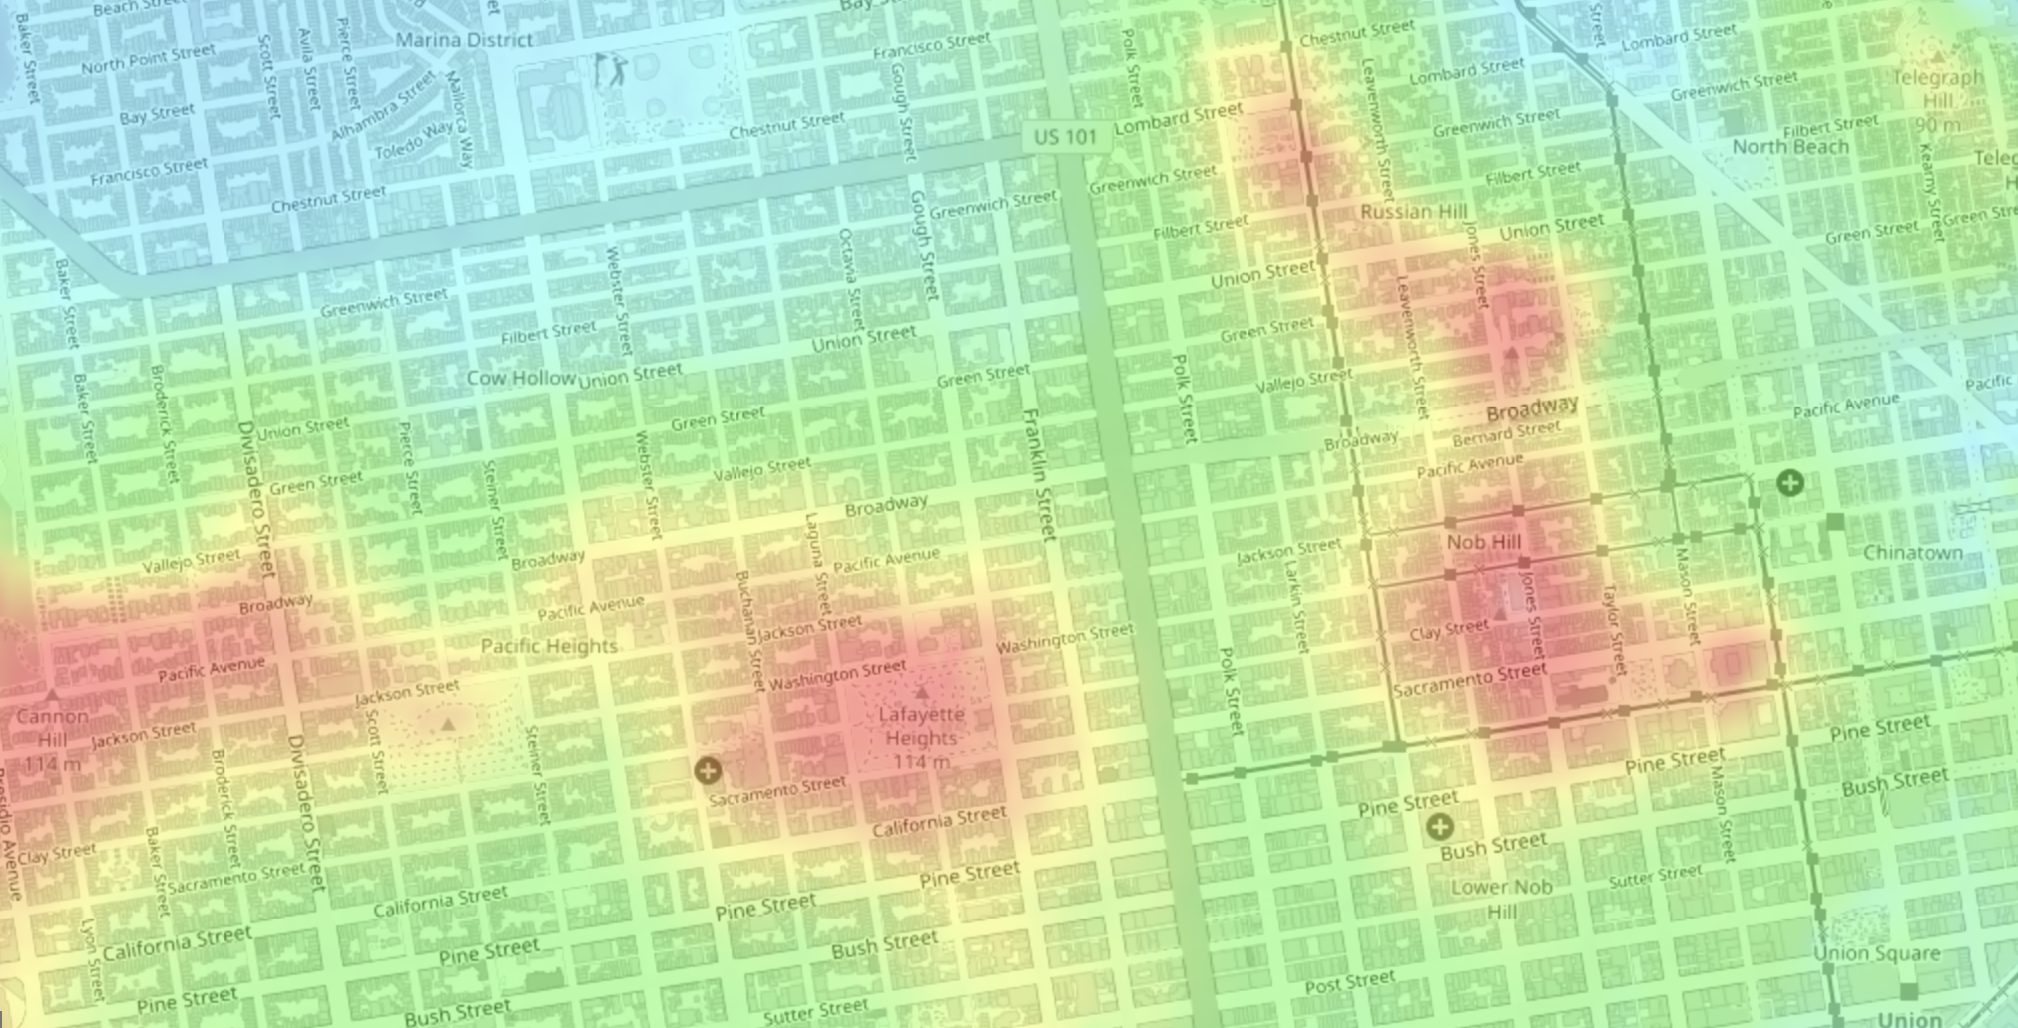

In [2]:
# Image of the area to be modelled
image = Image.open('/content/drive/MyDrive/topology.png')

# Display image
display(image)


**Resized and Processed Topology Map**

<ipython-input-3-a1e7cae1193d>:29: RuntimeWarning: overflow encountered in ubyte_scalars
  elevation[i, j] =  map[i, j, 0] - map[i, j, 1] + map[i, j, 2]


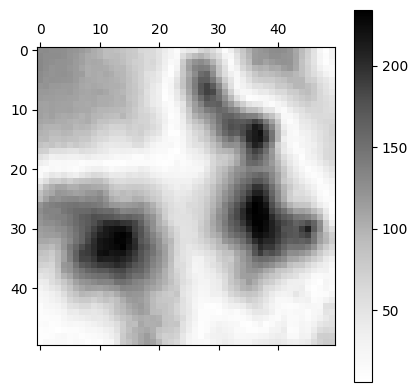

In [3]:
def load_topology(path):
    """
    Load an image file and extract elevation data using the red, green, and blue channels.

    Parameters
    -----------
    path : str
            The path to the image file.

    Returns
    -----------
    resized_elevation : ndarray
            A 2D numpy array representing the elevation data.
    
    """
    
    # Load the image using OpenCV
    map = cv2.imread(path)

    # Extract the shape of the image
    n, m, p = map.shape

    # Create a 2D numpy array to hold the elevation data
    elevation = np.zeros((n, m))

    # Extract the elevation data from the red, green, and blue channels
    for i in range(n):
        for j in range(m):
            elevation[i, j] =  map[i, j, 0] - map[i, j, 1] + map[i, j, 2]

    # Resize the elevation data to a 50x50 matrix
    resized_elevation = cv2.resize(elevation, (50, 50))

    # Display the elevation data as a grayscale image with a colorbar
    plt.matshow(resized_elevation, cmap='Greys')
    plt.colorbar()

    # Return the resized elevation data
    return resized_elevation

resized_elevation=load_topology('/content/drive/MyDrive/terrain2.jpeg')

# **Flood Simulation**

In [4]:
class Cell:
    """
    A class representing a single cell in a hydrological model.

    """
    def __init__(self, elevation, absorb_rate, evap_rate, ground_water_limit):
        """
        A method to create an instance of a Cell class with corresponding attributes.

        Parameters
        -----------
        elevation : float
            The elevation of the cell
        absorb_rate : float 
            The rate at which the cell absorbs water
        evap_rate : float 
            The rate at which the cell's water evaporates
        ground_water_limit : float 
            The maximum amount of ground water the cell can hold
        
        """

        self.elevation = elevation
        self.absorb_rate = absorb_rate
        self.evap_rate = evap_rate
        self.ground_water_limit = ground_water_limit 
        # The current amount of ground water in the cell
        self.ground_water = 0 
        # The amount of ground water in the cell after the next time step
        self.next_ground_water = 0 
        # The current depth of surface water in the cell
        self.water_depth = 0 
         # The depth of surface water in the cell after the next time step
        self.next_water_depth = 0


class Grid:
    """
    A class to create a grid of cells representing the desired topology and modelling the spread of water.
    
    """

    def __init__(self, shape, elevation_map, absorb_rate_map, evap_rate, ground_water_limit_map, plot=True):
        """
        Initializes a new Grid object.

        Parameters
        -----------
        shape : list of int
            The shape of the grid (number of rows, number of columns)
        elevation_map : ndarray
            A 2D array of the same shape as the grid, representing the elevation of each cell
        absorb_rate_map : ndarray
            A 2D array of the same shape as the grid, representing the water absorption rate of each cell
        evap_rate : float
            The rate at which water evaporates from each cell
        ground_water_limit_map : ndarray
            A 2D array of the same shape as the grid, representing the maximum amount of ground water that can be held in each cell
        
        """

        self.shape = shape

        # Initialize an empty grid
        self.cells = np.empty(shape=shape, dtype=object) 

        # Create a Cell object for each cell in the grid, and store it in self.cells
        for i in range(shape[0]):
            for j in range(shape[1]):
                self.cells[i, j] = Cell(elevation=elevation_map[i, j], absorb_rate=absorb_rate_map[i,j], evap_rate=evap_rate, ground_water_limit=ground_water_limit_map[i,j])
        
        if plot==True:
            # Create a new figure and axes for plotting the grid
            self.figure, self.axes = plt.subplots()

        # Initialize the step counter
        self.step_counter = 0

        self.flood=[]

    
    def get_neighbors(self, i, j):
        """
        Returns a list of the coordinates of the neighbors of the cell at (i, j).

        Parameters
        -----------
        i : int
            The row index of the cell
        j : int
            The column index of the cell

        Returns
        --------
        neighbors: list of tuples of int
            A list of the coordinates of the neighbors of the cell at (i, j)

        """

        neighbors = []

        # Iterate over the neighboring cells of the cell at (i, j)
        for dx in [-1, 0, 1]:
            for dy in [-1, 0, 1]:

                # Check that the neighboring cell is within the bounds of the grid and store the neighbors
                if i + dx >= 0 and i + dx < self.shape[0] and j + dy >= 0 and j + dy < self.shape[1]:
                    neighbors.append((i + dx, j + dy)) 

        return neighbors

    def simulate_rainfall(self,p_rain=1,low=1,high=3):
        """
        Simulates rainfall by adding a random amount of water to each cell in the grid.

        Parameters
        -----------
        p_rain : float
            The probability of a cell being rained on
        low : int
            The lower bound for the uniform distribution the amount of rain is sampled from
        high: int
            The higher bound for the uniform distribution the amount of rain is sampled from

        """
        # Iterate over all cells in the grid
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                if random.random()<p_rain:

                    # Add a random amount of water to the cell
                    self.cells[i, j].water_depth += sts.uniform.rvs(low, high)
                    self.cells[i, j].next_water_depth = self.cells[i, j].water_depth 


    def simulate_flooding(self,flood_threshold=0.5, move_frac=1):
        """
        Simulates the process of flooding for a single time step.
        This method iterates through all cells in the grid and updates their properties based on the rules of the model.
        It updates the water depth of the cell, the ground water level, and the water depth of neighboring cells.

        Parameters
        -----------
        flood_threshold : float
            The threshold amount of water in a cell to count is as flooded
        move_frac : float
            The fraction of water to be moved from the current cell to lower neighbours
            
        """

        # Go through all cells in the grid
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                diffs = []
                cell = self.cells[i, j]


                # Evaporation defined by the evaporation rate
                cell.water_depth -= cell.water_depth * cell.evap_rate


                # Absorbtion defined by the empty space left in the ground and absorbtion rate 
                if cell.ground_water < cell.ground_water_limit:
                    if cell.water_depth * cell.absorb_rate <= cell.ground_water_limit - cell.ground_water:

                        # When water is absorbed, decrease the amount of water from the current cell's surface and increase in the ground by the same amount
                        cell.next_ground_water += cell.water_depth * cell.absorb_rate
                        cell.next_water_depth -= cell.water_depth * cell.absorb_rate
                    else:
                        cell.next_ground_water += cell.ground_water_limit - cell.ground_water
                        cell.next_water_depth -= cell.ground_water_limit - cell.ground_water


                # Water flow to lower neighboring cells
                lower_neighbors = []
                diffs = []
                # Go through every neighbor 
                for ni, nj in self.get_neighbors(i, j):
                    neighbor = self.cells[ni, nj]

                    # If the neighbor's elevation and water level is lower than the current cell's elevation and water level, store corresponding differences and neighbors
                    if neighbor.elevation + neighbor.water_depth < cell.elevation + cell.water_depth :
                        diffs.append((cell.elevation + cell.water_depth) - (neighbor.elevation + neighbor.water_depth))
                        lower_neighbors.append(neighbor)
                            

                # For each lower neighbor and corresponding difference in elevation, increase neighbors' water level proportional to its elevation difference with the current cell            
                for idx, diff in enumerate(diffs):
                    lower_neighbors[idx].next_water_depth += (cell.water_depth*move_frac) * (diff / sum(diffs))

                # Move certain amount water to lower neighbors 
                if len(lower_neighbors) != 0:
                    cell.next_water_depth = cell.water_depth*(1-move_frac)

        flooded=0
        # Update water depth and ground water level for each cell
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                if self.cells[i, j].absorb_rate==1:
                    self.cells[i, j].water_depth = 0
                    self.cells[i, j].ground_water = self.cells[i, j].next_ground_water
                else:
                    self.cells[i, j].water_depth = self.cells[i, j].next_water_depth
                    self.cells[i, j].ground_water = self.cells[i, j].next_ground_water
                # Count flooded cells
                if self.cells[i, j].water_depth >flood_threshold:
                    flooded+=1

        # Find the proportion of flooded cells
        self.flood.append(flooded / (self.shape[0]*self.shape[1]))

        # Increment step counter
        self.step_counter += 1


    def observe(self):
        """
        Creates an observation of the current state of the simulation.
        This method generates a 2D image of the current water depth for each cell in the grid.

        Returns
        --------
        plot : matplotlib.image.AxesImage
            The image of the current state of the simulation

        """

        # Create a 2D array to store the water depth values for each cell
        water_levels = np.zeros((self.shape[0], self.shape[1]))

        # Iterate over each cell and record its water depth
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                water_levels[i, j] = self.cells[i, j].water_depth

        # Create a color plot of the water depths and set the title
        plot = self.axes.imshow(water_levels, cmap='Blues', vmax=np.amax(water_levels))
        self.axes.set_title(f'State at step {self.step_counter}')

        # Return the plot
        return plot


    def observe_groundwater(self):
        """
        Creates an observation of the current state of the groundwater level in the simulation.
        This method generates a 2D image of the current groundwater level for each cell in the grid.

        """

        # Create a 2D array to store the groundwater level values for each cell
        water_levels = np.zeros((self.shape[0], self.shape[1]))

        # Iterate over each cell and record its groundwater level
        for i in range(self.shape[0]):
            for j in range(self.shape[1]):
                water_levels[i, j] = self.cells[i, j].ground_water

        # Create a color plot of the groundwater levels with a color bar
        plt.imshow(water_levels)
        plt.colorbar()
        plt.show()


    def animate(self):
        """
        Animates the simulation by updating the state of the simulation over time.

        """

        self.observe()
        self.simulate_flooding()


In [5]:
def params_setup(elevation, absorbtion, evaporation, ground_water_lim):
    """
    Set up the parameters for a water flow simulation.

    Parameters
    ----------
    elevation : ndarray
        A 2D numpy array representing the elevation of each point on a map
    absorbtion : ndarray
        A 2D numpy array representing the rate at which water is absorbed by
        the ground at each point on a map
    evaporation : float
        The rate at which water evaporates from the ground
    ground_water_lim : ndarray
        A 2D numpy array representing the maximum amount of water that can be
        held in the ground at each point on a map

    Returns
    -------
    elevation_map : ndarray
        A 2D numpy array representing the elevation of each point on a map
    absorb_rate_map : ndarray
        A 2D numpy array representing the rate at which water is absorbed by
        the ground at each point on a map. Modified to account for parks with higher absorbtion soil
    evap_rate : float
        The rate at which water evaporates from the ground
    ground_water_limit_map : ndarray
        A 2D numpy array representing the maximum amount of water that can be
        held in the ground at each point on a map. Modified to account for parks with higher absorbtion soil

    """

    # Make copies of the input arrays so that we don't modify the originals
    elevation_map = np.copy(elevation)
    absorb_rate_map = np.copy(absorbtion)
    ground_water_limit_map = np.copy(ground_water_lim)

    # Set absorption rates and ground water limits for park 1
    for i in range(35, 38):
        for j in range(20, 23):
            absorb_rate_map[i, j] = 0.3
            ground_water_limit_map[i, j] = 3

    # Set absorption rates and ground water limits for park 2
    for i in range(35, 38):
        for j in range(10, 13):
            absorb_rate_map[i, j] = 0.3
            ground_water_limit_map[i, j] = 3

    # Return the updated maps along with the original evaporation rate
    return elevation_map, absorb_rate_map, evaporation, ground_water_limit_map



In [6]:
# Adapted from 
# Session 8. (n.d.). Forum. Forum.minerva.edu. Retrieved February 27, 2023, from https://forum.minerva.edu/app/courses/2571/sections/10241/classes/72155?course_id=2584
def make_animation(sim, total_frames, limit, steps_per_frame=1, interval=100):
    """
    Create an animation of a simulation.

    Parameters
    ----------
    sim : Simulation (class Grid object)
        The simulation to animate
    total_frames : int
        The total number of frames to animate
    steps_per_frame : int
        The number of simulation steps to perform for each frame of the animation
    interval : int
        The time in milliseconds between frames of the animation

    Returns
    -------
    output : IPython.display.HTML
        The HTML object that displays the animation

    """

    from matplotlib.animation import FuncAnimation
    from IPython.display import HTML
    from tqdm import tqdm

    def update(frame_number,limit=limit):
        """
        Update the simulation state and return the current state to be displayed.

        Parameters
        ----------
        frame_number : int
            The current frame number

        Returns
        -------
        list of ndarray
            The current state of the simulation

        """

        for i in range(steps_per_frame):

            # Update the simulation state
            sim.simulate_flooding() 
            step=0
            while step != limit:
                sim.simulate_rainfall()
                step+=1
        progress_bar.update(1)

        # Show the state as a list
        return [sim.observe()] 

    # Initialize the simulation grid with rainfall
    sim.simulate_rainfall()
    progress_bar = tqdm(total=total_frames)

    # Animate
    animation = FuncAnimation(
        sim.figure, update, init_func=lambda: [], frames=total_frames, interval=300)
    output = HTML(animation.to_html5_video())
    sim.figure.clf()
    return output

In [7]:
# Set up the parameters using the resized_elevation array, an absorption rate
# of 0.1, a default evaporation rate of 0.01, and a ground water limit of 4.
elevation_map_sf, absorb_rate_map_sf, evap_rate_sf, ground_water_limit_map_sf= params_setup(
    resized_elevation, np.array([[0.1]*50]*50), 0.01, np.array([[1]*50]*50))

# Create a grid and make animation
grid_sf= Grid([50, 50], elevation_map_sf, absorb_rate_map_sf, evap_rate_sf, ground_water_limit_map_sf)
make_animation(grid_sf, total_frames=20, steps_per_frame=1, limit=0)

100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


<Figure size 640x480 with 0 Axes>

# **Test Cases**

**Moutain in the middle**

In [8]:
def generate_mount_and_anim(size = 50, mountain_height=10, total_frames=20,steps_per_frame=1,limit=0):
    """
    Generate a mountain terrain and an animation of the water flow simulation.

    Parameters
    -----------
    size : int
        The size of the terrain array
    mountain_height : int
        The height of the mountain in the center of the terrain
    total_frames : int
        The total number of frames in the animation
    steps_per_frame : int
        The number of simulation steps per frame in the animation
    limit : float
        The rain limit for each cell in the terrain

    """
    # Create an array of zeros
    terrain = np.zeros((size, size))

    # Set the middle of the terrain to be a mountain
    center = size // 2
    terrain[center - 10:center + 10, center - 10:center + 10] = mountain_height

    # Show the terrain
    plt.imshow(terrain)
    plt.show()

    elevation_map, absorb_rate_map, evap_rate_map, ground_water_limit_map = params_setup(
        terrain,  np.array([[0.1]*50]*50), 0.01, np.array([[1]*50]*50))

    # Create a grid and make animation
    grid = Grid([size, size], elevation_map, absorb_rate_map, evap_rate_map, ground_water_limit_map)
    display(make_animation(grid, total_frames=total_frames, steps_per_frame=steps_per_frame, limit=limit))

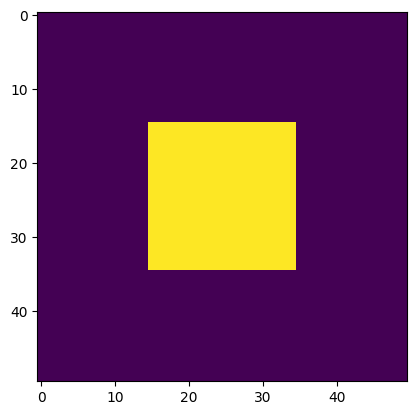

100%|██████████| 20/20 [00:06<00:00,  2.87it/s]


<Figure size 640x480 with 0 Axes>

In [9]:
generate_mount_and_anim()

**Flat terrain**

In [10]:
def generate_flat_and_anim(size = 50, total_frames=20,steps_per_frame=1,limit=0):
    """
    Generate a flat terrain and an animation of the water flow simulation.

    Parameters
    -----------
    size : int 
        The size of the terrain array
    total_frames : int 
        The total number of frames in the animation
    steps_per_frame : int 
        The number of simulation steps per frame in the animation
    limit : float 
        The rain limit for each cell in the terrain

    """
    # Define the dimensions of the array
    size = 50

    # Create an array of zeros
    terrain = np.zeros((size, size))

    # Show the terrain
    plt.imshow(terrain)
    plt.show()

    elevation_map, absorb_rate_map, evap_rate_map, ground_water_limit_map = params_setup(
        terrain,  np.array([[0.1]*50]*50), 0.01, np.array([[1]*50]*50))

    # Create a grid and make animation
    grid = Grid([size, size], elevation_map, absorb_rate_map, evap_rate_map, ground_water_limit_map)
    display(make_animation(grid, total_frames=total_frames, steps_per_frame=steps_per_frame, limit=limit))

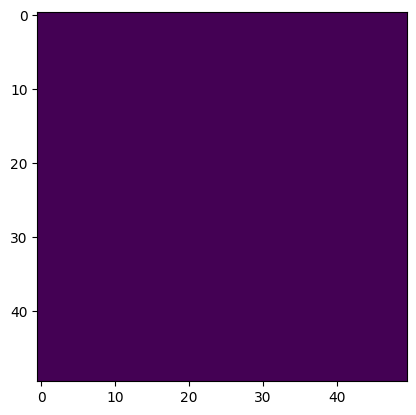

100%|██████████| 20/20 [00:07<00:00,  2.50it/s]


<Figure size 640x480 with 0 Axes>

In [11]:
generate_flat_and_anim()

**Steep Cliff**

In [12]:
def generate_cliff_and_anim(size = 50, total_frames=20,steps_per_frame=1,limit=0):
    """
    Generate a steep cliff terrain and an animation of the water flow simulation.

    Parameters
    -----------
    size : int 
        The size of the terrain array
    total_frames : int 
        The total number of frames in the animation
    steps_per_frame : int 
        The number of simulation steps per frame in the animation
    limit : float 
        The rain limit for each cell in the terrain

    """
    # Define a terrain
    terrain = np.zeros((50, 50))
    terrain[23:24, :] = 1.0
    terrain[24:25, :] = 2.0
    terrain[25:, :] = 3.0

    # Show the terrain
    plt.imshow(terrain)
    plt.show()

    elevation_map, absorb_rate_map, evap_rate_map, ground_water_limit_map = params_setup(
        terrain,  np.array([[0.1]*50]*50), 0.01, np.array([[1]*50]*50))

    # Create a grid and make animation
    grid = Grid([size, size], elevation_map, absorb_rate_map, evap_rate_map, ground_water_limit_map)
    display(make_animation(grid, total_frames=total_frames, steps_per_frame=steps_per_frame, limit=limit))

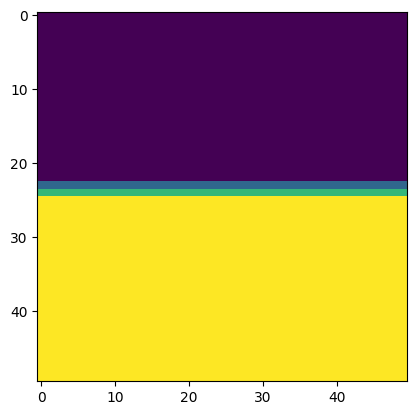

100%|██████████| 20/20 [00:06<00:00,  3.24it/s]


<Figure size 640x480 with 0 Axes>

In [13]:
generate_cliff_and_anim()

**Ground Water**

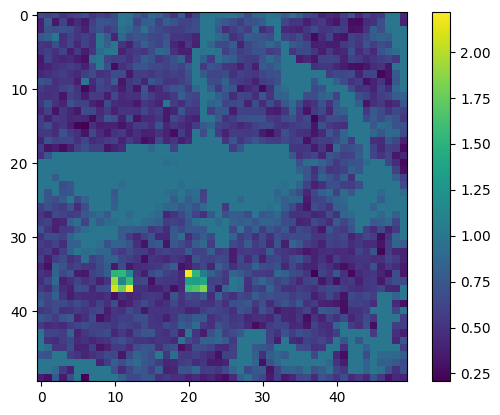

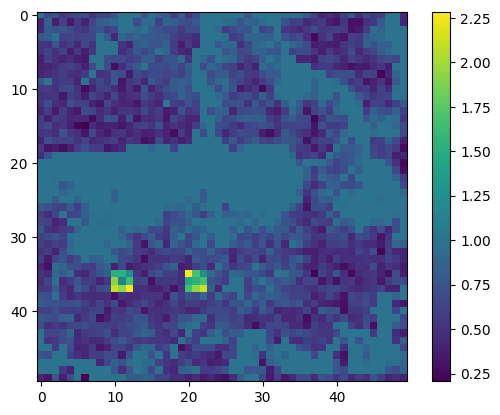

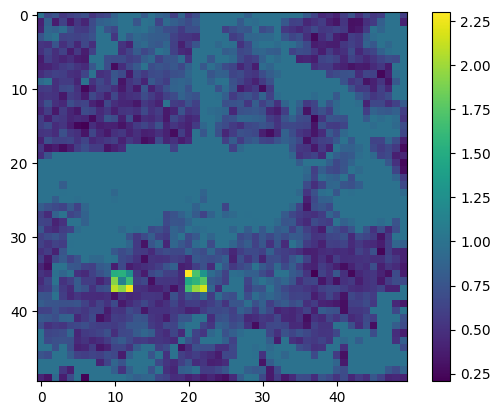

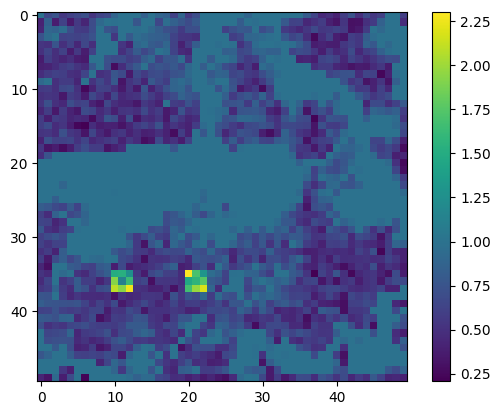

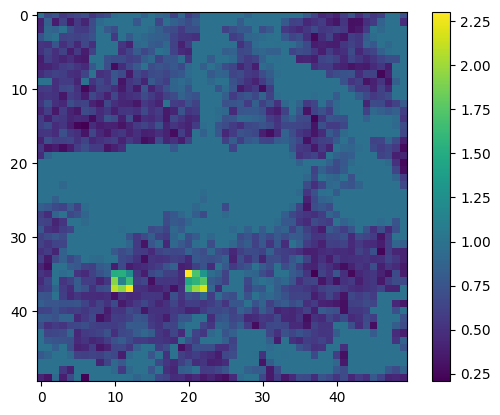

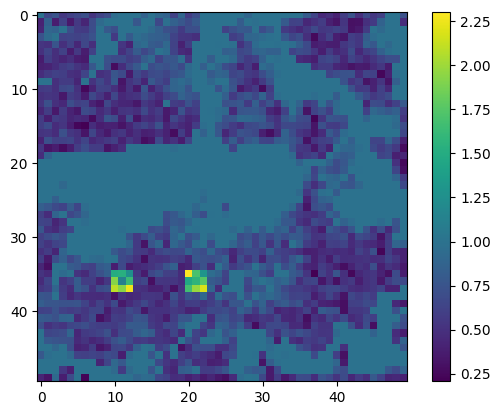

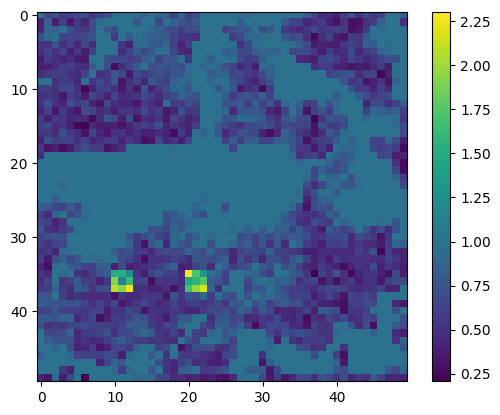

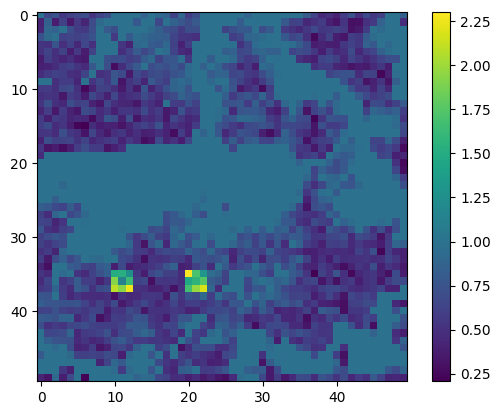

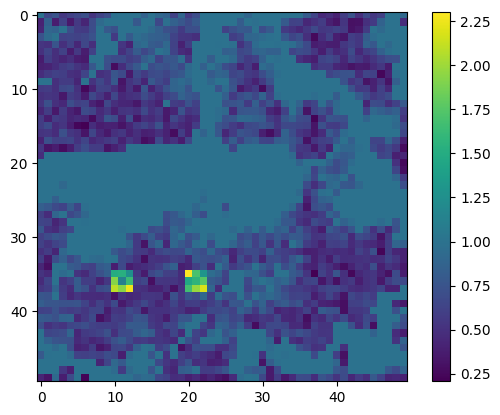

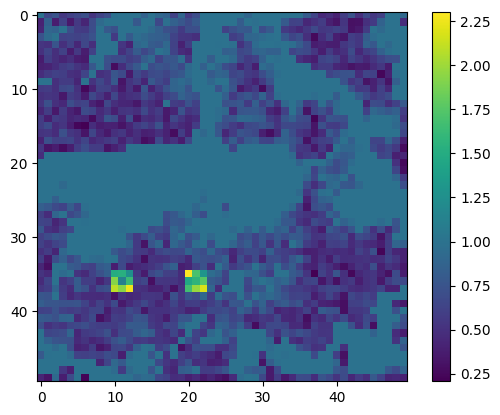

In [14]:
# Simulate initial rain
grid_sf.simulate_rainfall()

# Perform 10 updates and observe the groundwater levels at each step
for i in range(10):
    grid_sf.simulate_flooding()
    grid_sf.observe_groundwater()


# **Theoretical Analyses**

In [15]:
def cobweb_plot(p_e=0.5, x0=0.1, xmin=0, xmax=1, num_points=1000, num_iterations=20):
    """
    Plots the cobweb plot of the equation for a given set of parameters and initial condition.

    Parameters
    ----------
    p_f : float
        The value of `p_f` parameter in the equation
    p_e : float
        The value of `p_e` parameter in the equation
    x0 : float
        The initial value of `p_t`.
    xmin : float
        The minimum value of `p_t` to plot
    xmax : float
        The maximum value of `p_t` to plot
    num_points : int
        The number of points to plot between `xmin` and `xmax`
    num_iterations : int
        The number of iterations to run.

    Returns
    -------
    xn : float
        The final value of `p_t` (i.e., the stable state proportion of flooded cells)
        
    """
    # define the equation to plot
    def f(p_f, p_e):
        return (1-p_f)*(1-(1-p_e*p_f)**8) + p_f*p_e**8

    # set the range of x values to plot
    x = np.linspace(xmin, xmax, num_points)

    # plot the cobweb plot
    plt.plot(x, f(x, p_e), 'b-', label='p_t+1')
    plt.plot([xmin, xmax], [xmin, xmax], 'k-', label='p_t+1=p_t')
    plt.plot([x0, x0], [0, f(x0, p_e)], 'g-', label='p_t0')
    xn = x0
    for i in range(num_iterations):
        plt.plot([xn, xn], [xn, f(xn, p_e)], 'r--', linewidth=1)
        plt.plot([xn, f(xn, p_e)], [f(xn, p_e), f(xn, p_e)], 'r--', linewidth=1)
        xn = f(xn, p_e)

    plt.title(f'Cobweb Plot of Flooding Stable State Proportion for Initial Proportion of {x0}')
    plt.xlabel('Proportion of flooded cells at the current step (p_t)')
    plt.ylabel('Proportion of flooded cells at the next step (p_t+1)')
    plt.legend()
    plt.show()
    
    return xn

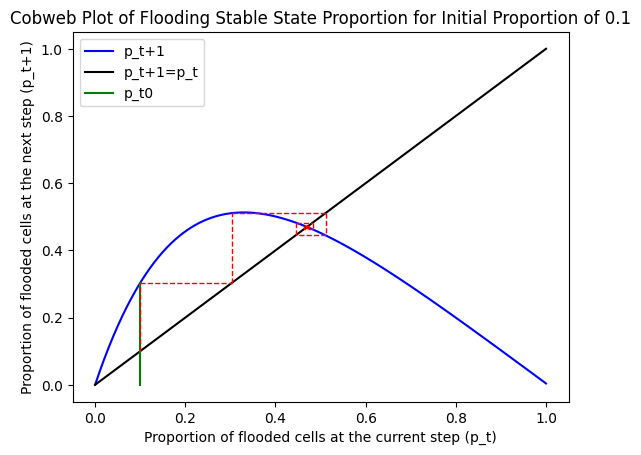

Stable state proportion of flooded cells:  0.46978720884559777


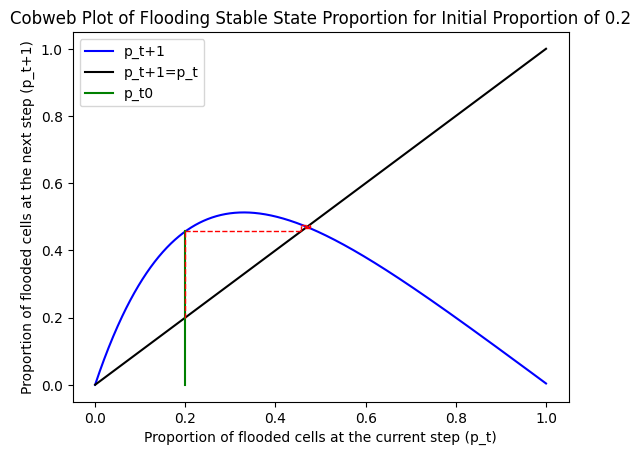

Stable state proportion of flooded cells:  0.46978636901738297


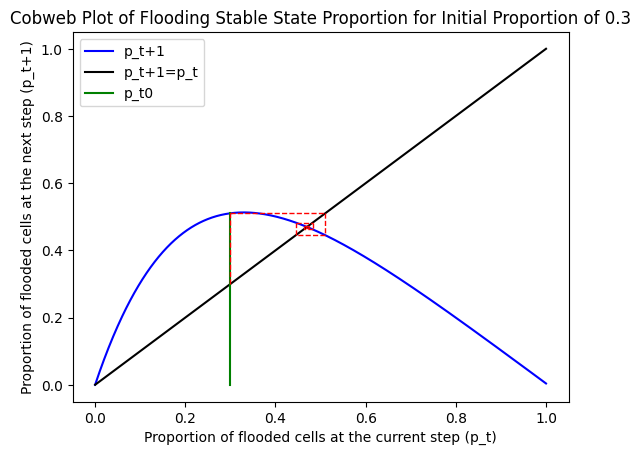

Stable state proportion of flooded cells:  0.4697856480540275


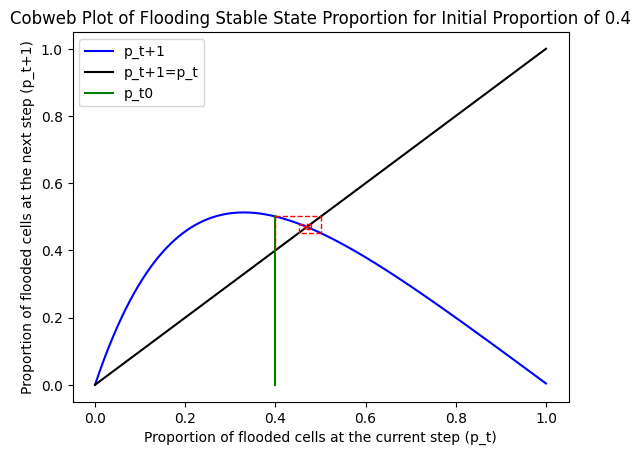

Stable state proportion of flooded cells:  0.4697857796787537


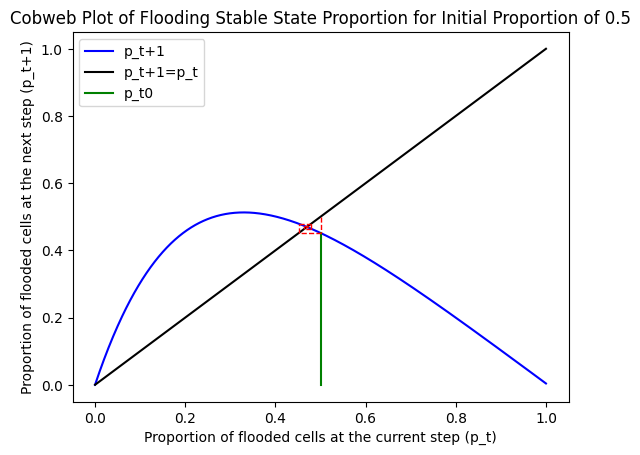

Stable state proportion of flooded cells:  0.46978642425438866


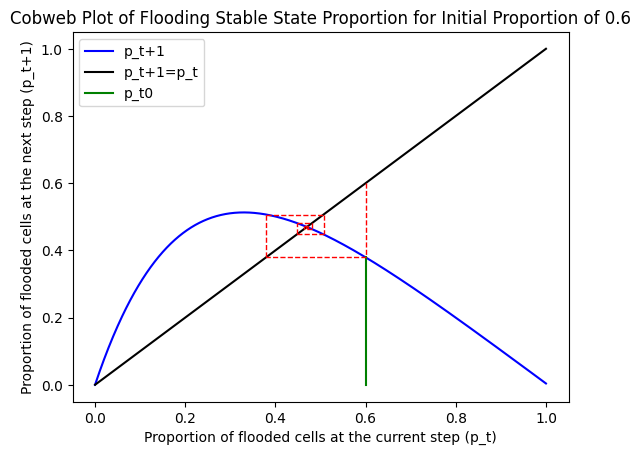

Stable state proportion of flooded cells:  0.46978710389705025


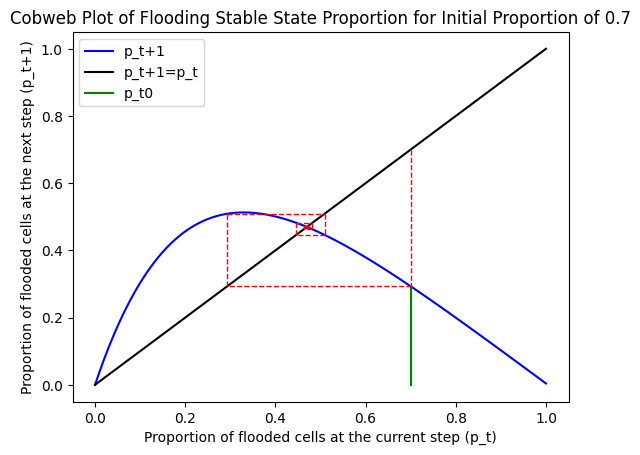

Stable state proportion of flooded cells:  0.46978716194684816


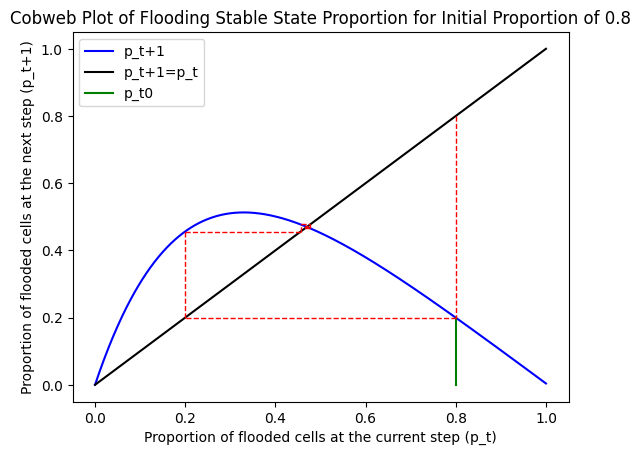

Stable state proportion of flooded cells:  0.46978588687525663


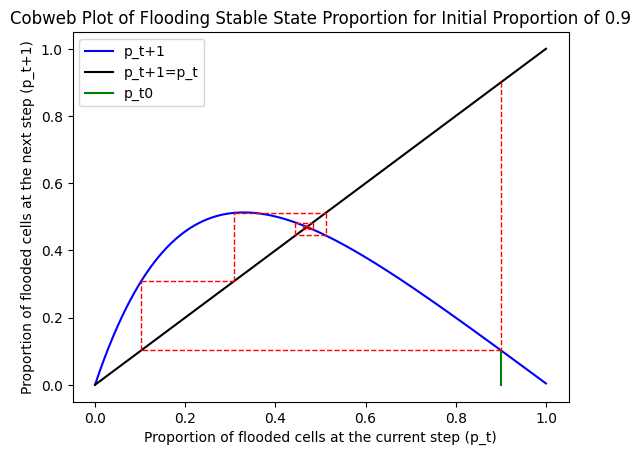

Stable state proportion of flooded cells:  0.4697843381832792


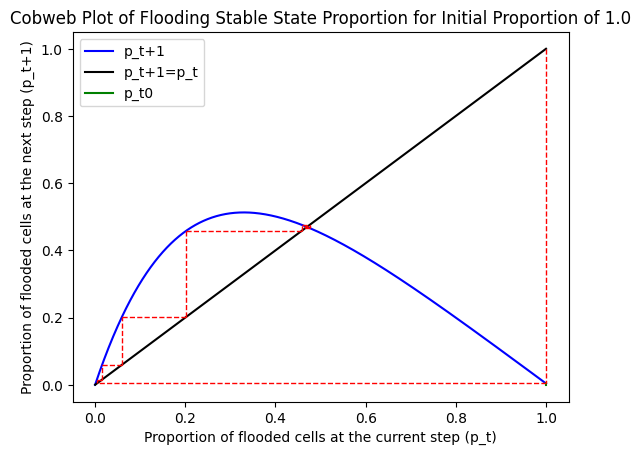

Stable state proportion of flooded cells:  0.4697877939646967


In [16]:
# Plot Cobweb plots for different initial conditions
for i in np.arange(0.1,1.1,0.1):
    xn=cobweb_plot(p_e=0.5, x0=round(i,2), xmin=0, xmax=1, num_points=1000, num_iterations=20)
    print('Stable state proportion of flooded cells: ',xn)

# **Compare Theoretical results to Empirical**

In [17]:
def run_sim_no_anim(sim, total_frames, limit=1, p_rain=1,flood_threshold=0,low=1,high=3):
    """
    Run the simulation for a set number of frames, with no animation.

    Parameters
    ----------
    sim : Grid class object
        An instance of the Grid class representing the simulation
    total_frames : int
        The total number of frames to simulate
    limit : int
        The number of frames to simulate rain for

    Returns
    -------
    sim : Grid class object
        The final state of the simulation after running for `total_frames` frames
        
    """
    for i in range(total_frames):
        # Poor rain for a set number of timesteps
        if i < limit:
            sim.simulate_rainfall(p_rain=p_rain,low=low,high=high)
        # Update the simulation state
        sim.simulate_flooding(flood_threshold=flood_threshold)
    return sim

In [18]:
def plot_flood_amount(rain_patterns_flood):
    """
    Plots the average final flooding proportions with corresponding CIs.

    Parameters
    ----------
    rain_patterns_flood : list of arrays
        A list of arrays containing the final flooding proportions for different rainfall durations

    Returns
    -------
    final_flood_amount : list
        A list of average final flood amounts across each simulation for each rainfall pattern
    ci_95_mean : list
        A list of 95% mean CI for each simulation for each rainfall pattern
    ci_95_data : list
        A list of 95% data CI for each simulation for each rainfall pattern

    """
    av_final_flood_amount=[]
    ci_95_mean=[]
    ci_95_data=[]
    
    # Compute 95 CI of the data and mean, as well as record the average flood proportion, for each rain duration
    for i in rain_patterns_flood:
        ci_95_mean.append((np.mean(i)+1.96*sts.sem(i))-(np.mean(i)-1.96*sts.sem(i)))
        ci_95_data.append(np.quantile(i,0.975)-np.quantile(i,0.025))
        av_final_flood_amount.append(np.mean(i))
        
    return av_final_flood_amount, ci_95_mean, ci_95_data

In [28]:
def final_flood_init_rain(values,num_reps):
    """
    Simulate the final flood levels in a grid for different initially flooded cells proportions.

    Parameters
    ----------
    values : list
        A list of initially flooded cells proportions
    num_reps : int
        The number of simulation repetitions to run for each initially flooded cells proportion

    Returns
    -------
    init_rain_flood : 2D list
        A list of flood levels for each initially flooded cells proportion and each simulation repetition

    """
    init_rain_flood=[]

    # For each initially flooded cells proportion
    for i in tqdm.tqdm(values):
        final_flood_level=[]

        # Certain number of repetitions
        for j in range(num_reps):
            grid_sf= Grid([50, 50], elevation_map_sf, np.array([[0]*50]*50), 0, np.array([[0]*50]*50),plot=False)
            grid_sf = run_sim_no_anim(grid_sf, total_frames=10,p_rain=i,low=1,high=1)
            
            # Store final flood level
            final_flood_level.append(grid_sf.flood[-1])
        init_rain_flood.append(final_flood_level)
    return init_rain_flood

In [29]:
init_rain_flood=final_flood_init_rain(values=np.arange(0.1,1.1,0.1),num_reps=20)

100%|██████████| 10/10 [02:02<00:00, 12.28s/it]


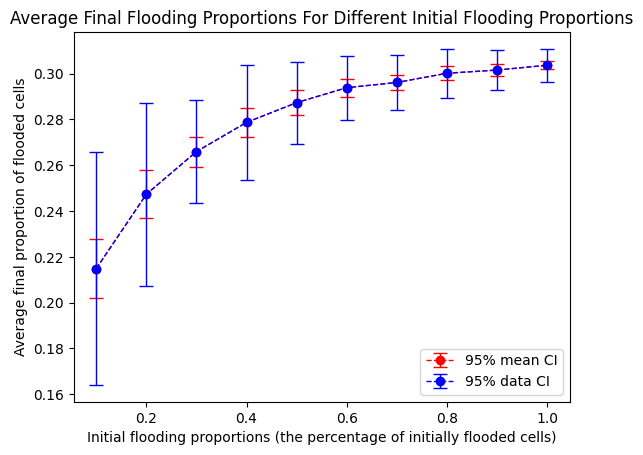

In [30]:
av_final_flood_amount, ci_95_mean, ci_95_data = plot_flood_amount(init_rain_flood)
# Produce an errorbar plot
plt.errorbar(np.arange(0.1,1.1,0.1),av_final_flood_amount, ci_95_mean,color='red', marker='o', capsize=5, linestyle='--', linewidth=1,label='95% mean CI') 
plt.errorbar(np.arange(0.1,1.1,0.1),av_final_flood_amount, ci_95_data,color='blue', marker='o', capsize=5, linestyle='--', linewidth=1,label='95% data CI') 
plt.title('Average Final Flooding Proportions For Different Initial Flooding Proportions')
plt.xlabel('Initial flooding proportions (the percentage of initially flooded cells)')
plt.ylabel('Average final proportion of flooded cells')
plt.legend()
plt.show()

# **Empirical Analyses**

**The effects of different rainfall patterns (durations) on the final flooding amount**

In [25]:
def final_flood_rain_pattern(values, num_reps):
    """
    Simulate the final flood levels in a grid for different rain patterns.

    Parameters
    ----------
    values : list
        A list of rain durations (in timesteps from the start)
    num_reps : int
        The number of simulation repetitions to run for each rain duration

    Returns
    -------
    rain_patterns_flood : 2D list
        A list of flood levels for each rain duration and each simulation repetition

    """
    rain_patterns_flood=[]

    # For each rain duration
    for i in tqdm.tqdm(values):
        final_flood_level=[]

        # Certain number of repetitions
        for j in range(num_reps):
            
            grid_sf= Grid([50, 50], elevation_map_sf, absorb_rate_map_sf, evap_rate_sf, ground_water_limit_map_sf,plot=False)
            grid_sf = run_sim_no_anim(grid_sf, total_frames=10,limit=i)

            # Store final flood level
            final_flood_level.append(grid_sf.flood[-1])
        rain_patterns_flood.append(final_flood_level)
    return rain_patterns_flood

In [26]:
rain_patterns_flood=final_flood_rain_pattern(values=np.arange(1,20,2),num_reps=20)

100%|██████████| 10/10 [05:13<00:00, 31.37s/it]


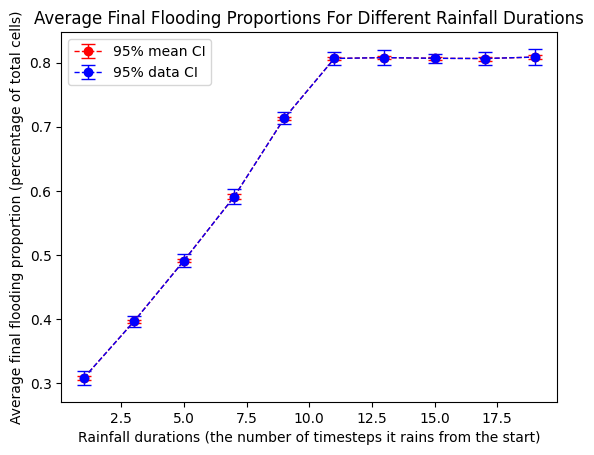

In [27]:
av_final_flood_amount, ci_95_mean, ci_95_data=plot_flood_amount(rain_patterns_flood)
# Produce an errorbar plot
plt.errorbar(np.arange(1,20,2),av_final_flood_amount, ci_95_mean,color='red', marker='o', capsize=5, linestyle='--', linewidth=1,label='95% mean CI') 
plt.errorbar(np.arange(1,20,2),av_final_flood_amount, ci_95_data,color='blue', marker='o', capsize=5, linestyle='--', linewidth=1,label='95% data CI') 
plt.title('Average Final Flooding Proportions For Different Rainfall Durations')
plt.xlabel('Rainfall durations (the number of timesteps it rains from the start)')
plt.ylabel('Average final flooding proportion (percentage of total cells)')
plt.legend()
plt.show()

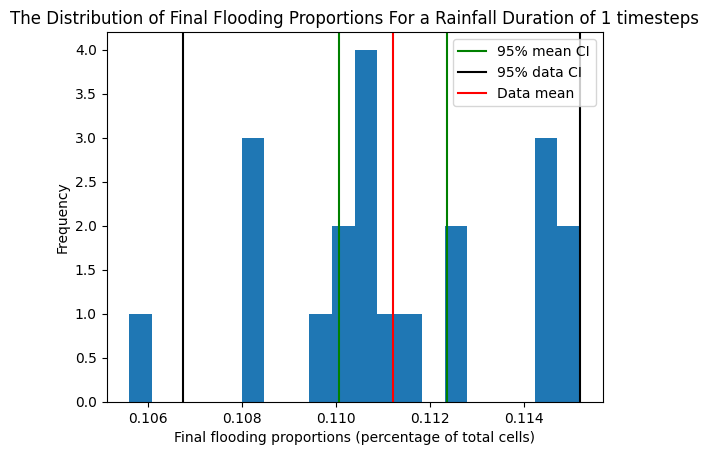

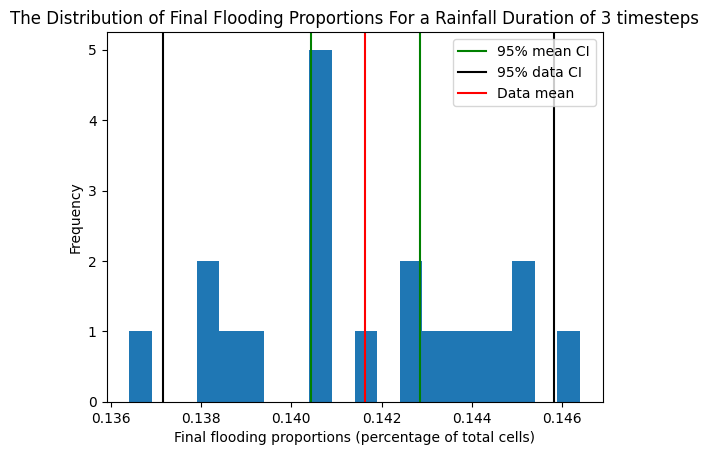

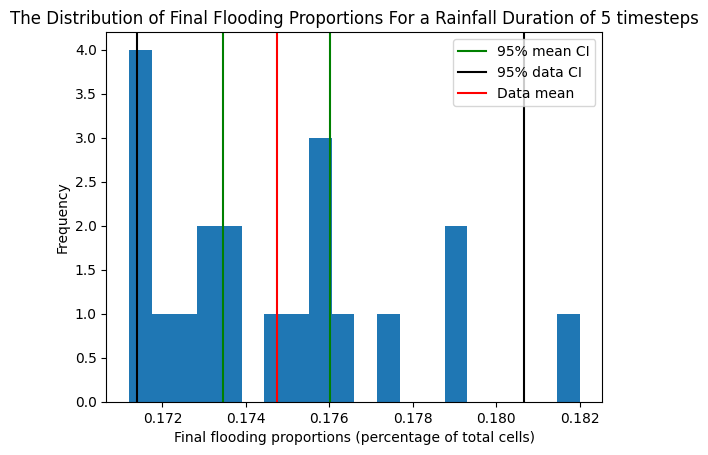

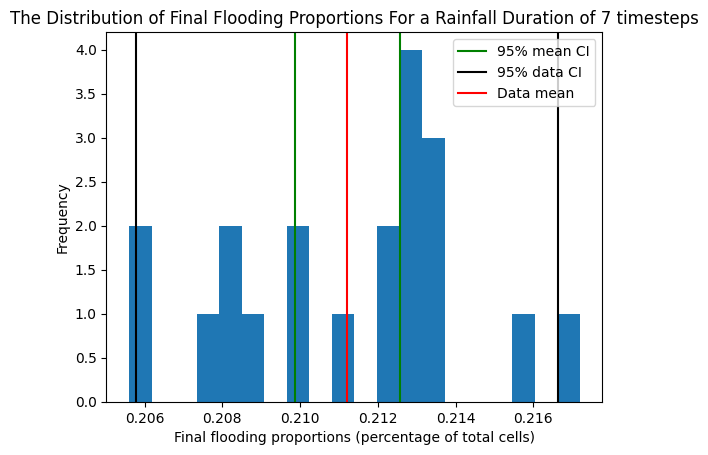

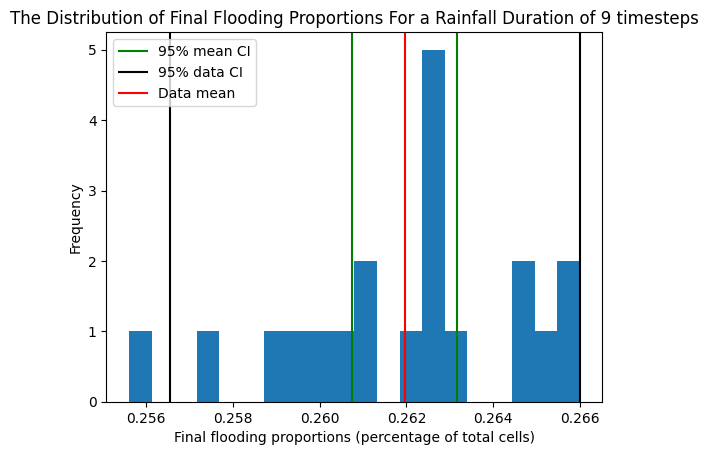

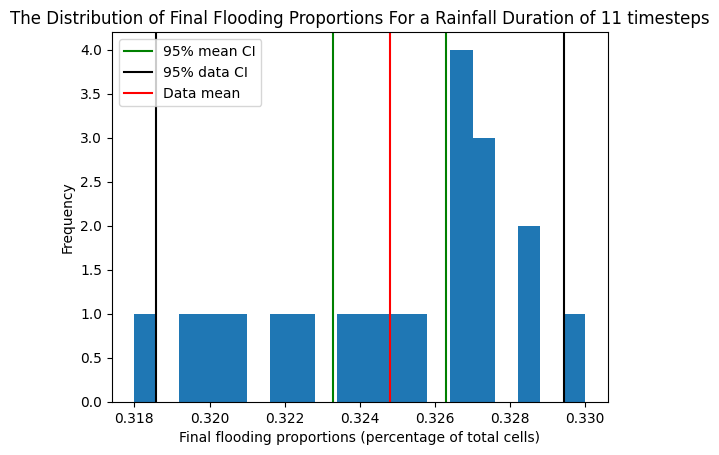

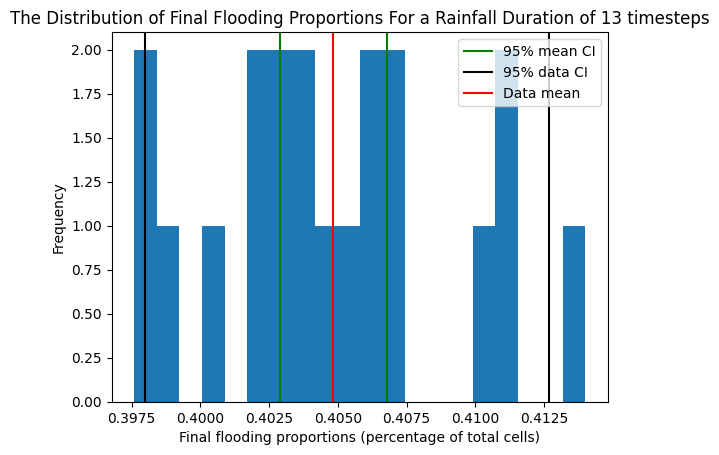

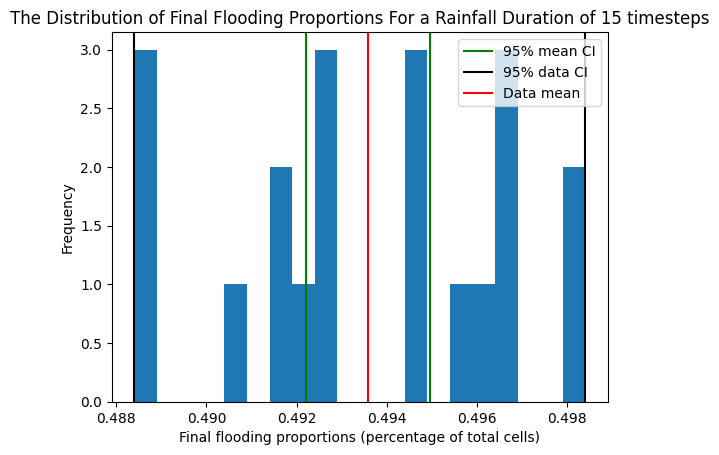

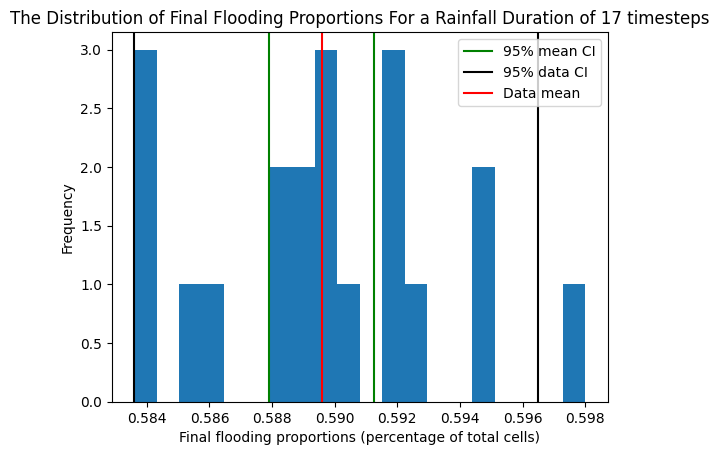

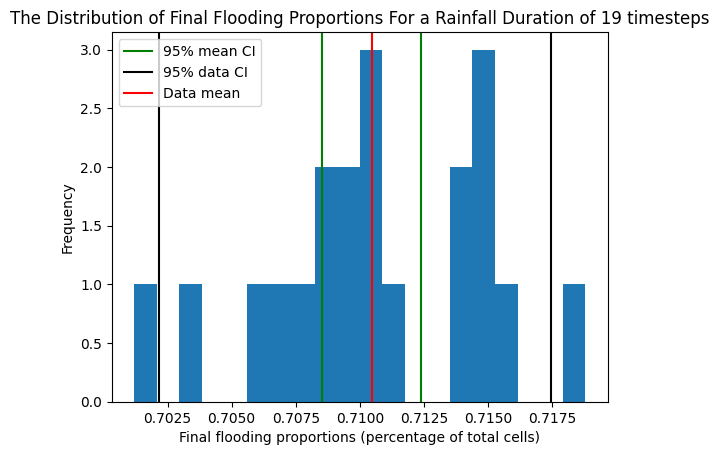

In [34]:
# Produce a histogram of the simulation final flooding proportions outputs for each rain duration with corresponding CIs
for idx, i in enumerate(rain_patterns_flood):
    plt.hist(i,bins=20)
    plt.axvline(np.mean(i)+1.96*sts.sem(i), color='green',label='95% mean CI')
    plt.axvline(np.mean(i)-1.96*sts.sem(i), color='green')
    plt.axvline(np.quantile(i,0.975), color='black',label='95% data CI')
    plt.axvline(np.quantile(i,0.025), color='black')
    plt.axvline(np.mean(i), color='red',label='Data mean' )
    plt.title(f'The Distribution of Final Flooding Proportions For a Rainfall Duration of {idx+(idx+1)} timesteps')
    plt.xlabel('Final flooding proportions (percentage of total cells)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

**The effects of drainage system on the final flooding amount**

In [35]:
def highest_flood_cells(grid,size=50,total_frames=10):
    """
    Get the coordinates of the cells with the highest water depth in a grid.

    Parameters
    ----------
    grid : Grid class object
        The grid object containing the simulated flood data
    size : int
        The size of the grid
    total_frames : int
        The number of simulation frames

    Returns
    -------
    coord : 2D list
        A list of coordinate pairs for the cells with the highest water depth
        Each pair is a list of two integers representing the row and column indices

    """
    # Create a 2D array to store the water depth values for each cell
    water_levels = np.zeros((size, size))
    # Iterate over each cell and record its water depth
    for i in range(50):
        for j in range(50):
            water_levels[i, j] = grid.cells[i, j].water_depth

    # Find 200 highest flooded cells and record their coordinates
    idxs = np.argsort(water_levels.ravel())[-200:]
    rows, cols = idxs//50, idxs%50

    coords=[]
    for i in range(len(rows)):
        coords.append([rows[i],cols[i]])

    return coords

In [36]:
def params_setup_drain(elevation, absorbtion, evaporation, ground_water_lim,drain_coord):
    """
    Set up the parameters for a water flow simulation with drainage system.
    Put drainage cells at the location of highest flooded cells.

    Parameters
    ----------
    elevation : ndarray
        A 2D numpy array representing the elevation of each point on a map
    absorbtion : ndarray
        A 2D numpy array representing the rate at which water is absorbed by
        the ground at each point on a map
    evaporation : float
        The rate at which water evaporates from the ground
    ground_water_lim : ndarray
        A 2D numpy array representing the maximum amount of water that can be
        held in the ground at each point on a map
    drain_coord : list
        A list of coordinates [row,col] for 10 cells with highest final water levels across the grid

    Returns
    -------
    elevation_map : ndarray
        A 2D numpy array representing the elevation of each point on a map
    absorb_rate_map : ndarray
        A 2D numpy array representing the rate at which water is absorbed by
        the ground at each point on a map. Modified to account for parks with higher absorbtion soil
    evap_rate : float
        The rate at which water evaporates from the ground
    ground_water_limit_map : ndarray
        A 2D numpy array representing the maximum amount of water that can be
        held in the ground at each point on a map. Modified to account for parks with higher absorbtion soil

    """

    # Make copies of the input arrays so that we don't modify the originals
    elevation_map = np.copy(elevation)
    absorb_rate_map = np.copy(absorbtion)
    ground_water_limit_map = np.copy(ground_water_lim)

    # Set absorption rates and ground water limits for park 1
    for i in range(35, 38):
        for j in range(20, 23):
            absorb_rate_map[i, j] = 0.3
            ground_water_limit_map[i, j] = 3

    # Set absorption rates and ground water limits for park 2
    for i in range(35, 38):
        for j in range(10, 13):
            absorb_rate_map[i, j] = 0.3
            ground_water_limit_map[i, j] = 3

    # Set absorption rates and ground water limits for drainage system
    for coord in drain_coord:
        absorb_rate_map[coord[0],coord[1]] = 1
        ground_water_limit_map[coord[0],coord[1]] = 1000000000

    # Return the updated maps along with the original evaporation rate
    return elevation_map, absorb_rate_map, evaporation, ground_water_limit_map

In [37]:
def drain_vs_no_drain(values,size=50,total_frames=20, num_reps=20):
    """
    Simulates flooding in a grid with and without a drainage system, and compares the proportion of flooded cells over time.

    Parameters
    -----------
    values : list
        A list of rain durations (in timesteps from the start)
    size : int
        The size of the square grid
    total_frames : int
        The number of simulation timesteps
    num_reps : int
        The number of simulations to run

    """
    # For each rain duration value
    for i in tqdm.tqdm(values):
        drain_flood=[]
        no_drain_flood=[]
        for j in range(num_reps):

            # No Drainage System
            elevation_map_sf, absorb_rate_map_sf, evap_rate_sf, ground_water_limit_map_sf= params_setup(
            resized_elevation, np.array([[0.1]*50]*50), 0.01, np.array([[1]*50]*50))

            grid_sf = Grid([size, size], elevation_map_sf, absorb_rate_map_sf, evap_rate_sf, ground_water_limit_map_sf,plot=False)
            grid_sf = run_sim_no_anim(grid_sf, total_frames=total_frames,limit=i)
            # Record coordinates of highest flooded cells
            coords = highest_flood_cells(grid_sf)
            no_drain_flood.append(grid_sf.flood)

            # Drainage System
            elevation_map_drain, absorb_rate_map_drain, evap_rate_drain, ground_water_limit_map_drain= params_setup_drain(
            resized_elevation, np.array([[0.1]*50]*50), 0.01, np.array([[1]*50]*50),coords)

            grid_drain = Grid([size, size], elevation_map_drain, absorb_rate_map_drain, evap_rate_drain, ground_water_limit_map_drain,plot=False)
            grid_drain = run_sim_no_anim(grid_drain, total_frames=total_frames,limit=i)
            drain_flood.append(grid_drain.flood)

        # Mean flooded cells proportions
        av_drain_flood = np.mean(drain_flood,axis=0)
        av_no_drain_flood = np.mean(no_drain_flood,axis=0)

        # 95% mean and data CI for drainage system
        ci_95_mean_drain = (av_drain_flood+1.96*sts.sem(drain_flood,axis=0))-(av_drain_flood-1.96*sts.sem(drain_flood,axis=0))
        ci_95_data_drain = np.quantile(drain_flood,0.975,axis=0)-np.quantile(drain_flood,0.025,axis=0)

        # 95% mean and data CI for no drainage system
        ci_95_mean_no_drain = (av_no_drain_flood+1.96*sts.sem(no_drain_flood,axis=0))-(av_no_drain_flood-1.96*sts.sem(no_drain_flood,axis=0))
        ci_95_data_no_drain = np.quantile(no_drain_flood,0.975,axis=0)-np.quantile(no_drain_flood,0.025,axis=0)

        # Plot errorbar plots
        plt.errorbar(np.arange(0,20),av_drain_flood, ci_95_mean_drain,color='red', marker='o', capsize=5, linestyle='--', linewidth=1,label='Drainage 95% mean CI') 
        plt.errorbar(np.arange(0,20),av_drain_flood, ci_95_data_drain,color='blue', marker='o', capsize=5, linestyle='--', linewidth=1,label='Drainage 95% data CI') 

        plt.errorbar(np.arange(0,20),av_no_drain_flood, ci_95_mean_no_drain,color='red', marker='o', capsize=5, linestyle='--', linewidth=1,label='No Drainage 95% mean CI') 
        plt.errorbar(np.arange(0,20),av_no_drain_flood, ci_95_data_no_drain,color='green', marker='o', capsize=5, linestyle='--', linewidth=1,label='No Drainage 95% data CI') 
        plt.title(f'Average Flooding Proportion Over Time for Drainage/No Drainage Systems \n for Rain Duration of {i} Timesteps')
        plt.xlabel('Time (number of timesteps)')
        plt.ylabel('Average proportion of flooded cells')
        plt.legend()
        plt.show()

  0%|          | 0/5 [00:00<?, ?it/s]

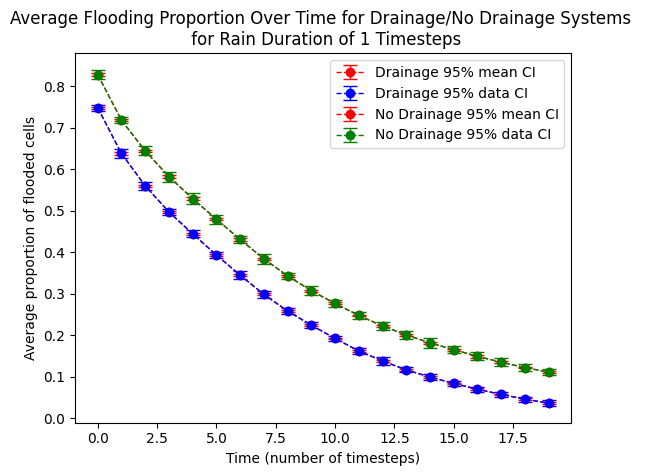

 20%|██        | 1/5 [00:56<03:47, 56.96s/it]

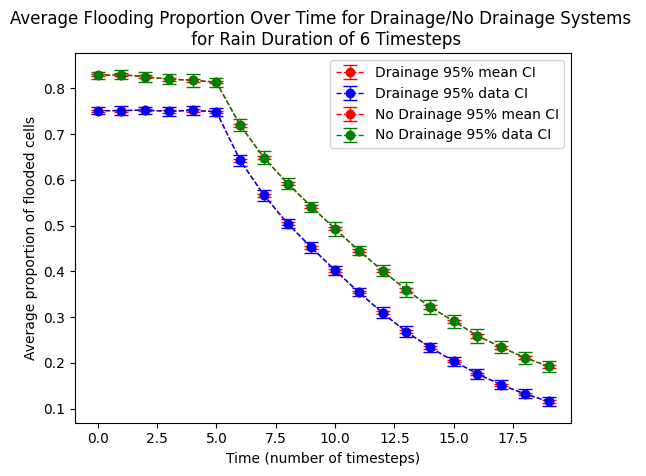

 40%|████      | 2/5 [02:13<03:25, 68.43s/it]

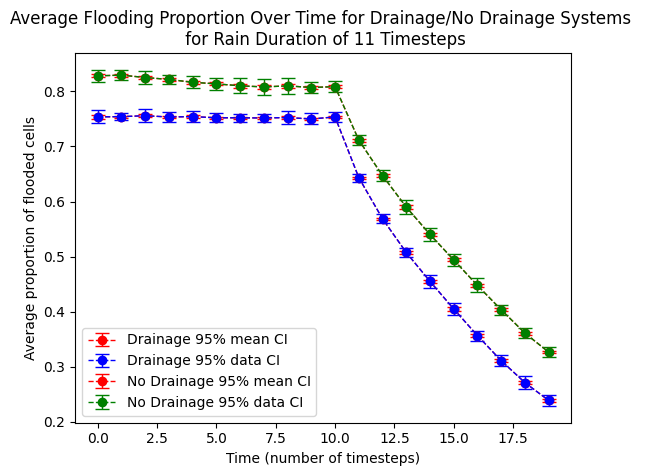

 60%|██████    | 3/5 [03:59<02:51, 85.55s/it]

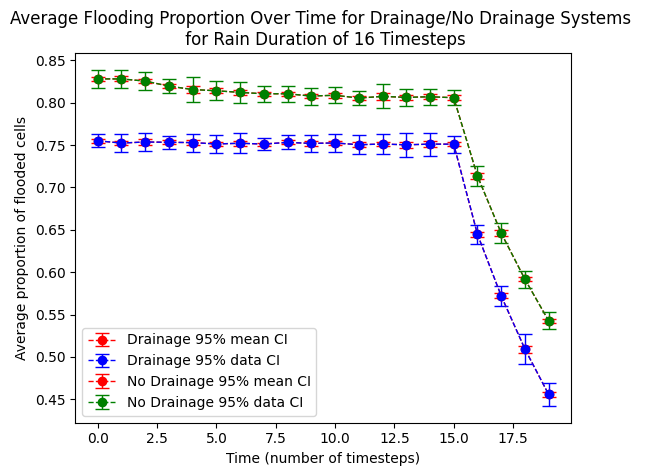

 80%|████████  | 4/5 [06:12<01:44, 104.43s/it]

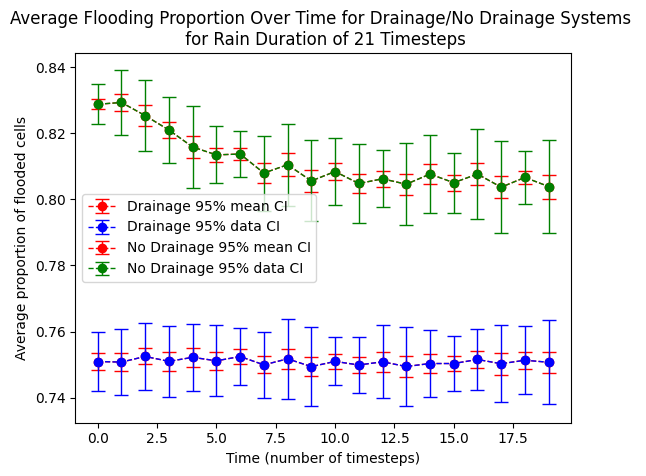

100%|██████████| 5/5 [08:46<00:00, 105.29s/it]


In [38]:
drain_vs_no_drain(values=np.arange(1,22,5))